In [1]:
# Imports
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import json
import country_converter as coco
import matplotlib.pyplot as plt

# Loading owid data to sql database

In [2]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [3]:
owid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=['date'], dayfirst = True, sep=',', skip_blank_lines = False)

In [4]:
db_conn.execute("DROP TABLE IF EXISTS owid CASCADE;")
owid = owid[(owid.location == 'Italy') | (owid.location=='Japan') | (owid.location == 'Netherlands')]
toDrop = ['continent','total_deaths','new_deaths','new_deaths_smoothed','total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million','total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities','life_expectancy',
       'human_development_index', 'excess_mortality_cumulative_absolute',
       'excess_mortality_cumulative', 'excess_mortality',
       'excess_mortality_cumulative_per_million']
toDrop = [x for x in toDrop if x in owid.columns]
owid.drop(toDrop, axis = 1, inplace=True)
owid.to_sql("owid", db_conn, if_exists='replace')
pd.read_sql_table('owid', db_conn)

,index,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,hospital_beds_per_thousand
0,99855,ITA,Italy,2020-01-31,2.0,2.0,NaN,0.034,0.034,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
1,99856,ITA,Italy,2020-02-01,2.0,0.0,NaN,0.034,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
2,99857,ITA,Italy,2020-02-02,2.0,0.0,NaN,0.034,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
3,99858,ITA,Italy,2020-02-03,2.0,0.0,NaN,0.034,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
4,99859,ITA,Italy,2020-02-04,2.0,0.0,NaN,0.034,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,142354,NLD,Netherlands,2022-10-13,8475771.0,0.0,3382.714,484282.838,0.000,193.279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2951,142355,NLD,Netherlands,2022-10-14,8486811.0,11040.0,3302.286,484913.634,630.796,188.684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2952,142356,NLD,Netherlands,2022-10-15,8486811.0,0.0,3302.286,484913.634,0.000,188.684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2953,142357,NLD,Netherlands,2022-10-16,8486811.0,0.0,3302.286,484913.634,0.000,188.684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32


In [5]:
pd.unique(owid['iso_code'])

array(['ITA', 'JPN', 'NLD'], dtype=object)

In [6]:
db_conn.execute("DROP VIEW IF EXISTS owidWY CASCADE;")
query = '''
CREATE OR REPLACE VIEW owidWY AS 
SELECT *,
CAST(EXTRACT(WEEK FROM date) AS int) AS week,
CAST(EXTRACT(YEAR FROM date) AS int) AS year
FROM owid
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM owidWY',db_conn))

       index iso_code     location       date  total_cases  new_cases  \
0      99855      ITA        Italy 2020-01-31          2.0        2.0   
1      99856      ITA        Italy 2020-02-01          2.0        0.0   
2      99857      ITA        Italy 2020-02-02          2.0        0.0   
3      99858      ITA        Italy 2020-02-03          2.0        0.0   
4      99859      ITA        Italy 2020-02-04          2.0        0.0   
...      ...      ...          ...        ...          ...        ...   
2950  142354      NLD  Netherlands 2022-10-13    8475771.0        0.0   
2951  142355      NLD  Netherlands 2022-10-14    8486811.0    11040.0   
2952  142356      NLD  Netherlands 2022-10-15    8486811.0        0.0   
2953  142357      NLD  Netherlands 2022-10-16    8486811.0        0.0   
2954  142358      NLD  Netherlands 2022-10-17    8486843.0       32.0   

      new_cases_smoothed  total_cases_per_million  new_cases_per_million  \
0                    NaN                    0.0

# Loading covariants data to sql

In [7]:
covarRaw = pd.read_json('https://raw.githubusercontent.com/hodcroftlab/covariants/07b0ea786205ad7269c09d46d2f7b13ef01b667e/cluster_tables/EUClusters_data.json')
dfs = []

for i in range(len(covarRaw.index)):
    country = covarRaw.index[i]
    if not country in ['Netherlands','Italy','Japan']:
        continue
    dtn = covarRaw['countries'][i]
    dtn['iso_code'] = coco.convert(country)
    df = pd.DataFrame.from_dict(dtn)
    df['date'] = pd.to_datetime(df['week'])
    df.drop('week',axis=1,inplace=True)
    dfs.append(df)
    
covarRaw = None
covar = pd.concat(dfs)
covar


,total_sequences,"20I (Alpha, V1)","20H (Beta, V2)","20J (Gamma, V3)",21A (Delta),21I (Delta),21J (Delta),21K (Omicron),21L (Omicron),22A (Omicron),...,20A/S:439K,S:677H.Robin1,20A.EU2,20A/S:98F,20B/S:626S,20B/S:1122L,iso_code,date,20A/S:126A,20C/S:80Y
0,421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,JPN,2020-04-27,NaN,NaN
1,117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,JPN,2020-05-11,NaN,NaN
2,149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,JPN,2020-05-25,NaN,NaN
3,191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,JPN,2020-06-08,NaN,NaN
4,389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,JPN,2020-06-22,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,56.0,...,0.0,NaN,0.0,0.0,0.0,NaN,ITA,2022-08-15,0.0,0.0
61,1270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,69.0,...,0.0,NaN,0.0,0.0,0.0,NaN,ITA,2022-08-29,0.0,0.0
62,1064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,37.0,...,0.0,NaN,0.0,0.0,0.0,NaN,ITA,2022-09-12,0.0,0.0
63,1099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,55.0,...,0.0,NaN,0.0,0.0,0.0,NaN,ITA,2022-09-26,0.0,0.0


In [8]:
db_conn.execute("DROP TABLE IF EXISTS covar CASCADE;")
covar.to_sql("covar", db_conn, if_exists='replace')

193

# Loading event cancel data to sql

In [9]:
eventsRaw = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/c3m_cancel_public_events.csv", sep=',', skip_blank_lines = False)
eventsRaw.drop(['Unnamed: 0', 'country_name','region_code','region_name','jurisdiction'],axis=1,inplace=True)

dfs= []

# getting data in desired row per unique date country pair format, which requires transposing the date per column format of the raw data 
for iso in ['NLD','JPN','ITA']:
    df = eventsRaw[eventsRaw['country_code']==iso]
    df.drop('country_code',axis=1,inplace=True)
    df= df.T
    df.columns = ['event_cancellation_level']
    df['date'] = pd.to_datetime(df.index)
    df['iso_code'] = iso
    dfs.append(df)

eventsRaw = None
events = pd.concat(dfs)
events
    

/tmp/ipykernel_71/1508122095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('country_code',axis=1,inplace=True)
/tmp/ipykernel_71/1508122095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('country_code',axis=1,inplace=True)
/tmp/ipykernel_71/1508122095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('country_code',axis=1,inplace=True)


,event_cancellation_level,date,iso_code
01Jan2020,0.0,2020-01-01,NLD
02Jan2020,0.0,2020-01-02,NLD
03Jan2020,0.0,2020-01-03,NLD
04Jan2020,0.0,2020-01-04,NLD
05Jan2020,0.0,2020-01-05,NLD
...,...,...,...
13Oct2022,0.0,2022-10-13,ITA
14Oct2022,0.0,2022-10-14,ITA
15Oct2022,0.0,2022-10-15,ITA
16Oct2022,0.0,2022-10-16,ITA


In [10]:
db_conn.execute("DROP TABLE IF EXISTS events CASCADE;")
events.to_sql("events", db_conn, if_exists='replace')

63

# Joining all relevant data in single sql view

In [11]:
#Joining variant data to owid data
db_conn.execute("DROP VIEW IF EXISTS owidcovar CASCADE;")
query = '''
CREATE OR REPLACE VIEW owidcovar AS 
SELECT 
    owidWY.*, "total_sequences", "20I (Alpha, V1)", "20H (Beta, V2)", "20J (Gamma, V3)", "21A (Delta)", 
    "21I (Delta)", "21J (Delta)", "21K (Omicron)", "21L (Omicron)", "22A (Omicron)", "22B (Omicron)", "22C (Omicron)", 
    "22D (Omicron)", "21B (Kappa)", "21D (Eta)", "21F (Iota)", "21G (Lambda)", "21H (Mu)", "20B/S:732A", "20E (EU1)", 
    "21C (Epsilon)", "20A/S:439K", "S:677H.Robin1", "20A.EU2", "20A/S:98F", "20B/S:626S", "20B/S:1122L", "20A/S:126A", "20C/S:80Y"
FROM owidWY
LEFT JOIN covar ON (owidWY.date = covar.date AND owidWY.iso_code = covar.iso_code);
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM owidcovar',db_conn))

       index iso_code     location       date  total_cases  new_cases  \
0     101797      JPN        Japan 2020-01-22          2.0        NaN   
1     101798      JPN        Japan 2020-01-23          2.0        0.0   
2     101799      JPN        Japan 2020-01-24          2.0        0.0   
3     101800      JPN        Japan 2020-01-25          2.0        0.0   
4     101801      JPN        Japan 2020-01-26          4.0        2.0   
...      ...      ...          ...        ...          ...        ...   
2950  102795      JPN        Japan 2022-10-16   21786304.0    29662.0   
2951  142357      NLD  Netherlands 2022-10-16    8486811.0        0.0   
2952  100845      ITA        Italy 2022-10-17   23114013.0    14030.0   
2953  102796      JPN        Japan 2022-10-17   21801676.0    15372.0   
2954  142358      NLD  Netherlands 2022-10-17    8486843.0       32.0   

      new_cases_smoothed  total_cases_per_million  new_cases_per_million  \
0                    NaN                    0.0

In [12]:
#Joining event cancellation data to owid and variant data
db_conn.execute("DROP VIEW IF EXISTS all_relevant CASCADE;")
query = '''
CREATE OR REPLACE VIEW all_relevant AS 
SELECT 
    owidcovar.*, event_cancellation_level
FROM owidcovar
LEFT JOIN events ON (owidcovar.date = events.date AND owidcovar.iso_code = events.iso_code);
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM all_relevant',db_conn))

       index iso_code     location       date  total_cases  new_cases  \
0     101797      JPN        Japan 2020-01-22          2.0        NaN   
1     101798      JPN        Japan 2020-01-23          2.0        0.0   
2     101799      JPN        Japan 2020-01-24          2.0        0.0   
3     101800      JPN        Japan 2020-01-25          2.0        0.0   
4     101801      JPN        Japan 2020-01-26          4.0        2.0   
...      ...      ...          ...        ...          ...        ...   
2950  102795      JPN        Japan 2022-10-16   21786304.0    29662.0   
2951  142357      NLD  Netherlands 2022-10-16    8486811.0        0.0   
2952  100845      ITA        Italy 2022-10-17   23114013.0    14030.0   
2953  102796      JPN        Japan 2022-10-17   21801676.0    15372.0   
2954  142358      NLD  Netherlands 2022-10-17    8486843.0       32.0   

      new_cases_smoothed  total_cases_per_million  new_cases_per_million  \
0                    NaN                    0.0

# Creating views for success factors

In [13]:
#getting the relevant kpi data for cases (excluding variant distribution for now)
db_conn.execute("DROP VIEW IF EXISTS cases CASCADE;")
query = '''
CREATE OR REPLACE VIEW cases AS 
SELECT iso_code, date,new_cases_per_million, new_cases_smoothed_per_million, reproduction_rate
FROM all_relevant
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM cases',db_conn))

     iso_code       date  new_cases_per_million  \
0         JPN 2020-01-22                    NaN   
1         JPN 2020-01-23                  0.000   
2         JPN 2020-01-24                  0.000   
3         JPN 2020-01-25                  0.000   
4         JPN 2020-01-26                  0.016   
...       ...        ...                    ...   
2950      JPN 2022-10-16                238.034   
2951      NLD 2022-10-16                  0.000   
2952      ITA 2022-10-17                236.832   
2953      JPN 2022-10-17                123.358   
2954      NLD 2022-10-17                  1.828   

      new_cases_smoothed_per_million  reproduction_rate  
0                                NaN                NaN  
1                                NaN                NaN  
2                                NaN                NaN  
3                                NaN                NaN  
4                                NaN                NaN  
...                              ...   

In [14]:
#getting the relevant kpi data for cases (including variant distribution)
db_conn.execute("DROP VIEW IF EXISTS casesplus CASCADE;")
query = '''
CREATE OR REPLACE VIEW casesplus AS 
SELECT iso_code, date,new_cases_per_million, new_cases_smoothed_per_million, reproduction_rate,
    "total_sequences", "20I (Alpha, V1)", "20H (Beta, V2)", "20J (Gamma, V3)", "21A (Delta)", 
    "21I (Delta)", "21J (Delta)", "21K (Omicron)", "21L (Omicron)", "22A (Omicron)", "22B (Omicron)", "22C (Omicron)", 
    "22D (Omicron)", "21B (Kappa)", "21D (Eta)", "21F (Iota)", "21G (Lambda)", "21H (Mu)", "20B/S:732A", "20E (EU1)", 
    "21C (Epsilon)", "20A/S:439K", "S:677H.Robin1", "20A.EU2", "20A/S:98F", "20B/S:626S", "20B/S:1122L", "20A/S:126A", "20C/S:80Y"
FROM all_relevant
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM casesplus',db_conn))

     iso_code       date  new_cases_per_million  \
0         JPN 2020-01-22                    NaN   
1         JPN 2020-01-23                  0.000   
2         JPN 2020-01-24                  0.000   
3         JPN 2020-01-25                  0.000   
4         JPN 2020-01-26                  0.016   
...       ...        ...                    ...   
2950      JPN 2022-10-16                238.034   
2951      NLD 2022-10-16                  0.000   
2952      ITA 2022-10-17                236.832   
2953      JPN 2022-10-17                123.358   
2954      NLD 2022-10-17                  1.828   

      new_cases_smoothed_per_million  reproduction_rate  total_sequences  \
0                                NaN                NaN              NaN   
1                                NaN                NaN              NaN   
2                                NaN                NaN              NaN   
3                                NaN                NaN              NaN   
4      

In [15]:
#getting the relevant kpi data for hospitalizations
db_conn.execute("DROP VIEW IF EXISTS hospitalizations, weeklyHos CASCADE;")
query = '''
CREATE OR REPLACE VIEW hospitalizations AS 
SELECT all_relevant.iso_code, date, icu_patients_per_million, weekly_icu_admissions_per_million, hosp_patients_per_million
FROM all_relevant
ORDER BY all_relevant.iso_code ASC, date ASC
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM hospitalizations',db_conn))

     iso_code       date  icu_patients_per_million  \
0         ITA 2020-01-31                       NaN   
1         ITA 2020-02-01                       NaN   
2         ITA 2020-02-02                       NaN   
3         ITA 2020-02-03                       NaN   
4         ITA 2020-02-04                       NaN   
...       ...        ...                       ...   
2950      NLD 2022-10-13                     2.628   
2951      NLD 2022-10-14                     2.114   
2952      NLD 2022-10-15                       NaN   
2953      NLD 2022-10-16                       NaN   
2954      NLD 2022-10-17                     2.571   

      weekly_icu_admissions_per_million  hosp_patients_per_million  
0                                   NaN                        NaN  
1                                   NaN                        NaN  
2                                   NaN                        NaN  
3                                   NaN                        NaN  
4     

In [16]:
#getting the relevant kpi data for vaccinations
query = '''
CREATE OR REPLACE VIEW vaccinations AS 
SELECT iso_code, date, people_fully_vaccinated_per_hundred, total_boosters_per_hundred,new_vaccinations_smoothed_per_million
FROM all_relevant
'''
db_conn.execute(query)
print(pd.read_sql('SELECT * FROM vaccinations',db_conn))

     iso_code       date  people_fully_vaccinated_per_hundred  \
0         JPN 2020-01-22                                  NaN   
1         JPN 2020-01-23                                  NaN   
2         JPN 2020-01-24                                  NaN   
3         JPN 2020-01-25                                  NaN   
4         JPN 2020-01-26                                  NaN   
...       ...        ...                                  ...   
2950      JPN 2022-10-16                                82.57   
2951      NLD 2022-10-16                                  NaN   
2952      ITA 2022-10-17                                80.97   
2953      JPN 2022-10-17                                  NaN   
2954      NLD 2022-10-17                                  NaN   

      total_boosters_per_hundred  new_vaccinations_smoothed_per_million  
0                            NaN                                    NaN  
1                            NaN                                    NaN

# Plotting the data simply to increase data understanding

In [17]:
def simplePlot(db_conn,isoCode, factor, lastN=-1):
    df = pd.read_sql('SELECT * FROM ' + factor,db_conn)
    df = df[df.iso_code==isoCode]
    if lastN > 0:
        df = df.tail(lastN)
    kpis = [x for x in df.columns if not x in ['iso_code','date'] ]
    for kpi in kpis:
        print(kpi)
        plt.plot(df.index,kpi,data=df)
        plt.title(kpi + ' in ' + isoCode)
        plt.xticks(rotation=90)
        plt.show()

icu_patients_per_million


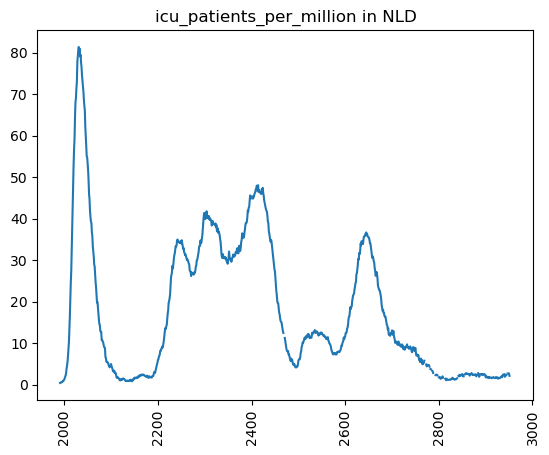

weekly_icu_admissions_per_million


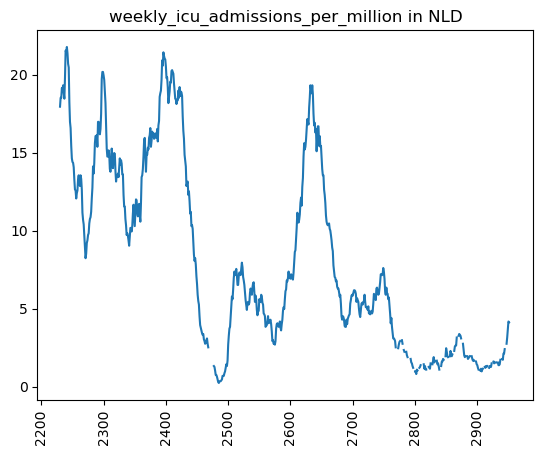

hosp_patients_per_million


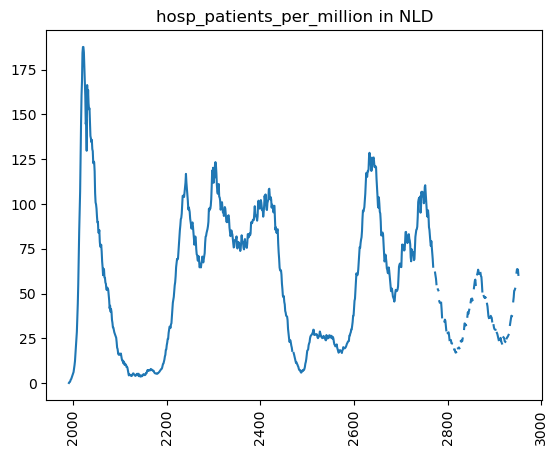

icu_patients_per_million


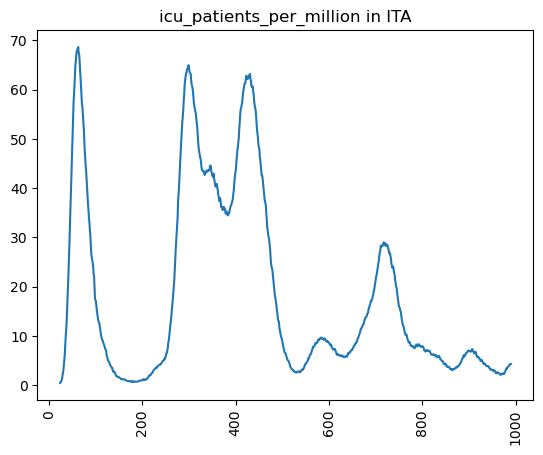

weekly_icu_admissions_per_million


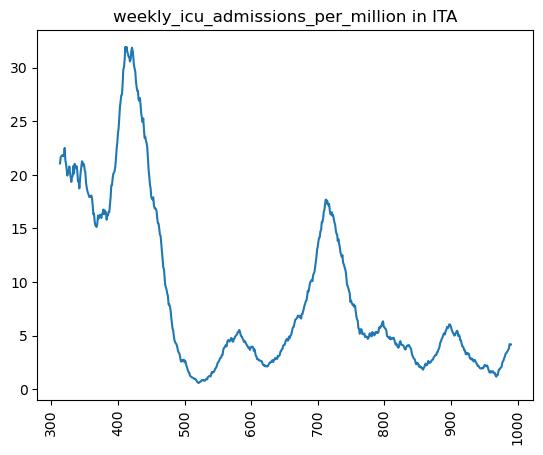

hosp_patients_per_million


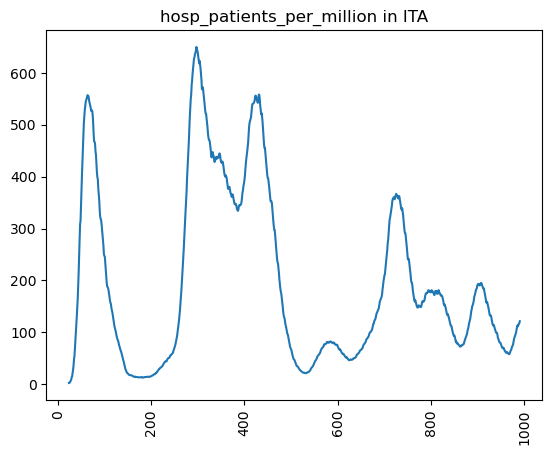

icu_patients_per_million


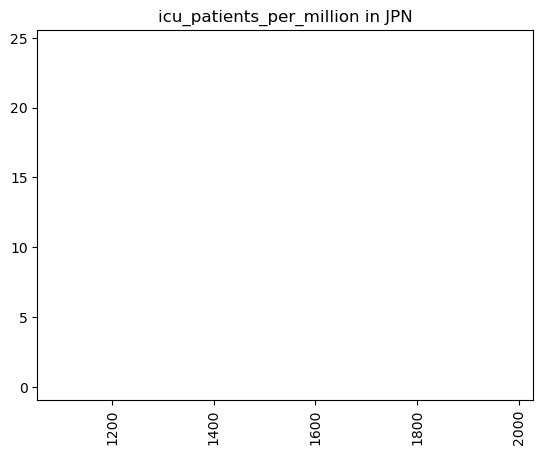

weekly_icu_admissions_per_million


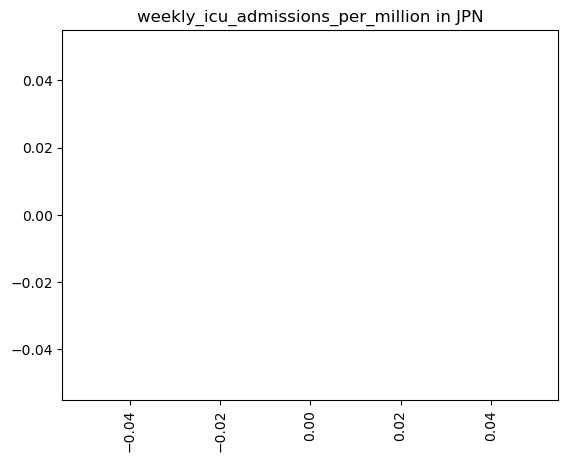

hosp_patients_per_million


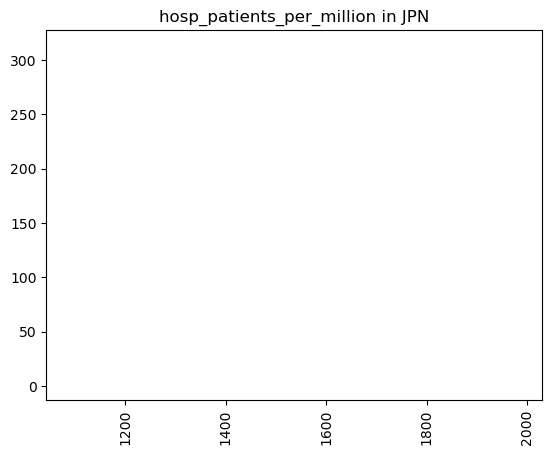

In [18]:
lastN = 2000
simplePlot(db_conn,'NLD','hospitalizations',lastN)
simplePlot(db_conn,'ITA','hospitalizations',lastN)
simplePlot(db_conn,'JPN','hospitalizations',lastN)

new_cases_per_million


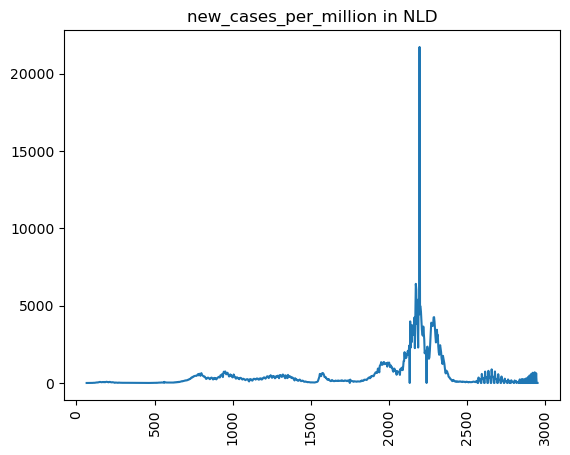

new_cases_smoothed_per_million


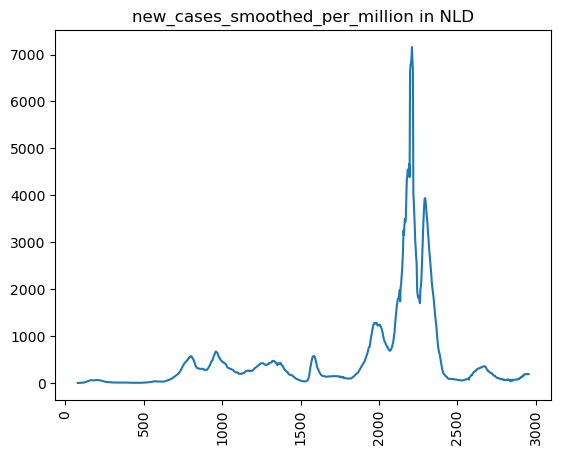

reproduction_rate


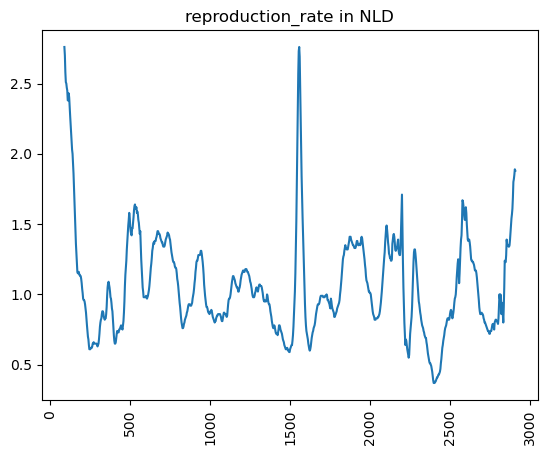

new_cases_per_million


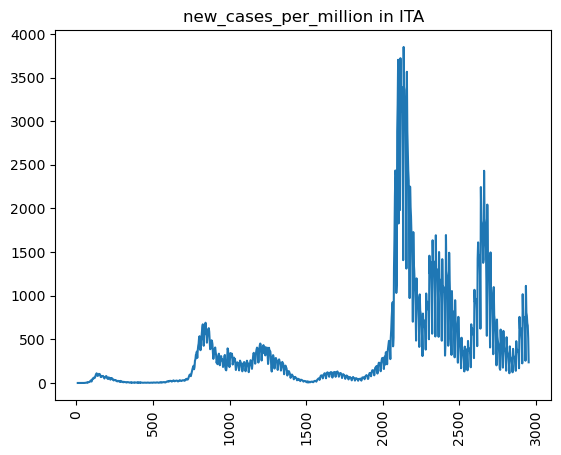

new_cases_smoothed_per_million


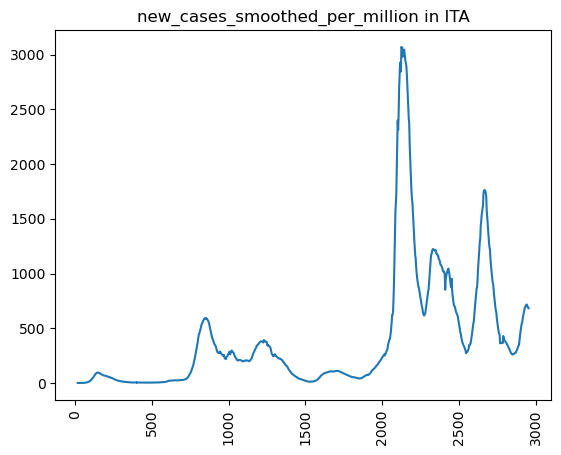

reproduction_rate


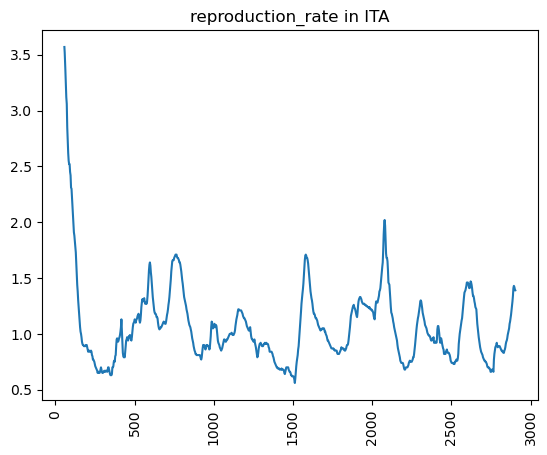

new_cases_per_million


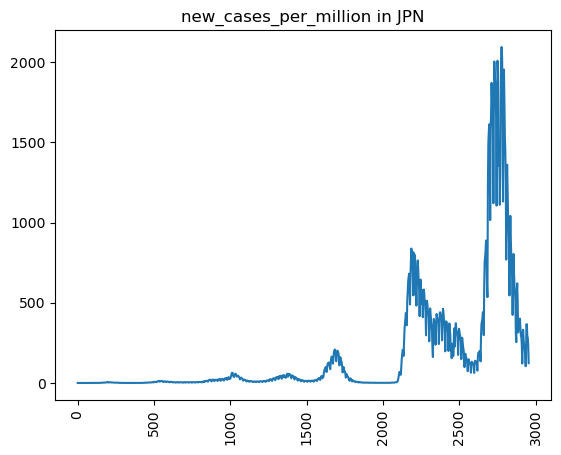

new_cases_smoothed_per_million


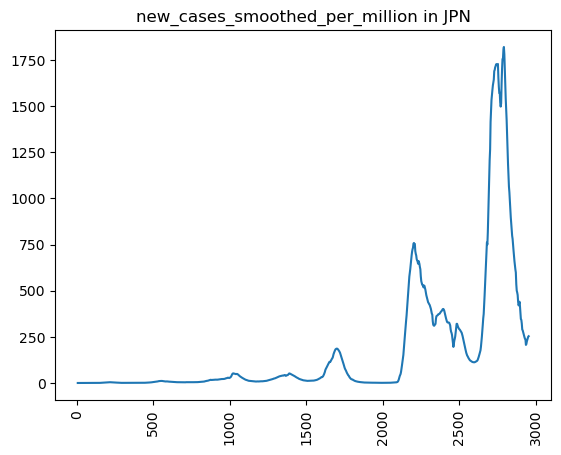

reproduction_rate


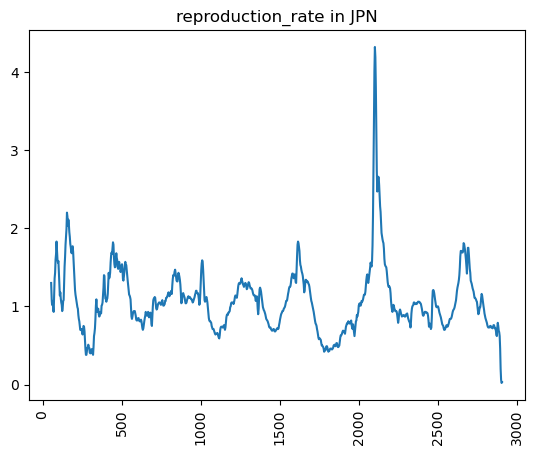

In [19]:
lastN = 1000
simplePlot(db_conn,'NLD','cases',lastN)
simplePlot(db_conn,'ITA','cases',lastN)
simplePlot(db_conn,'JPN','cases',lastN)

people_fully_vaccinated_per_hundred


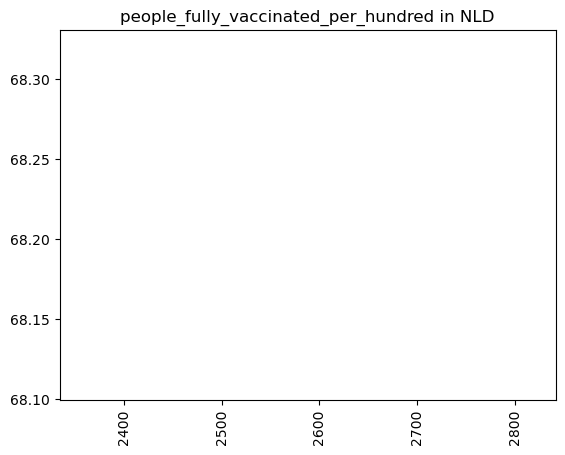

total_boosters_per_hundred


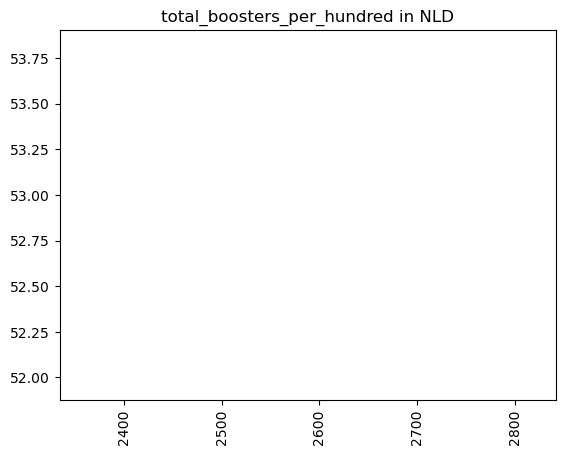

new_vaccinations_smoothed_per_million


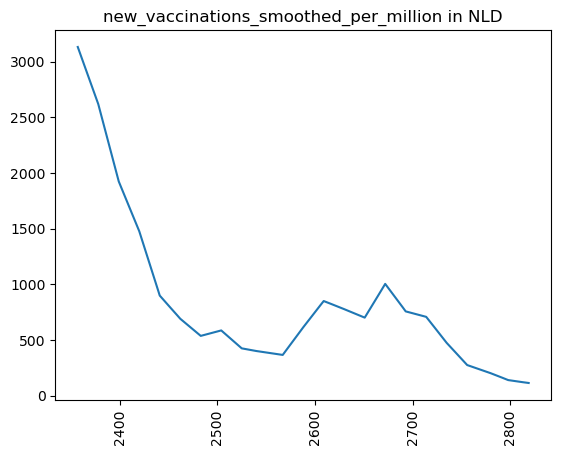

people_fully_vaccinated_per_hundred


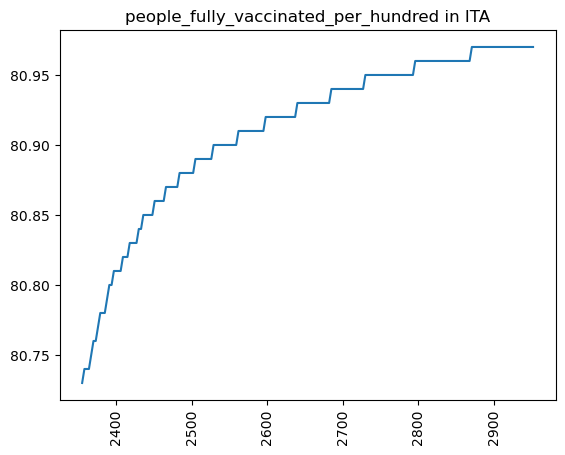

total_boosters_per_hundred


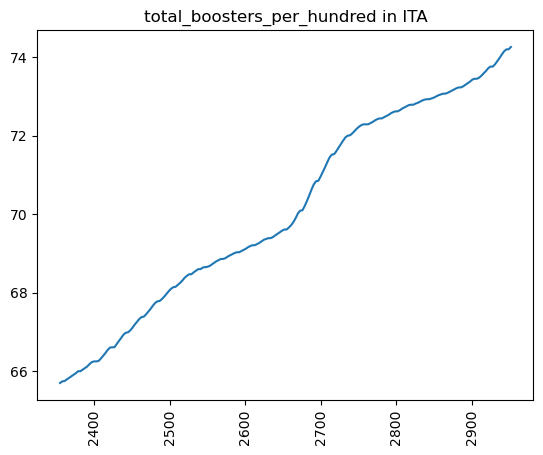

new_vaccinations_smoothed_per_million


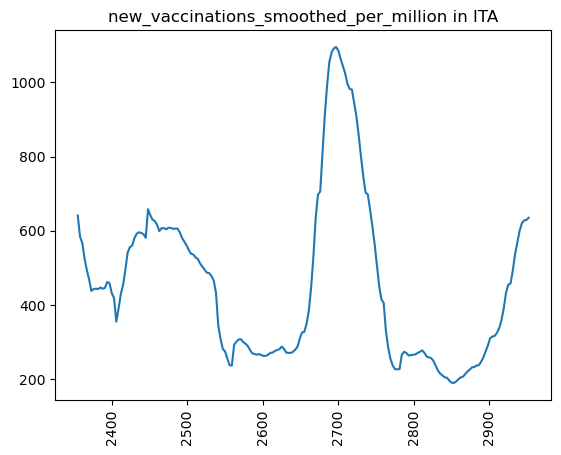

people_fully_vaccinated_per_hundred


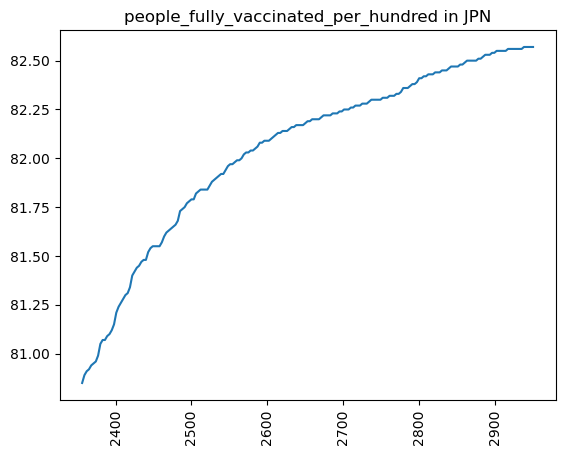

total_boosters_per_hundred


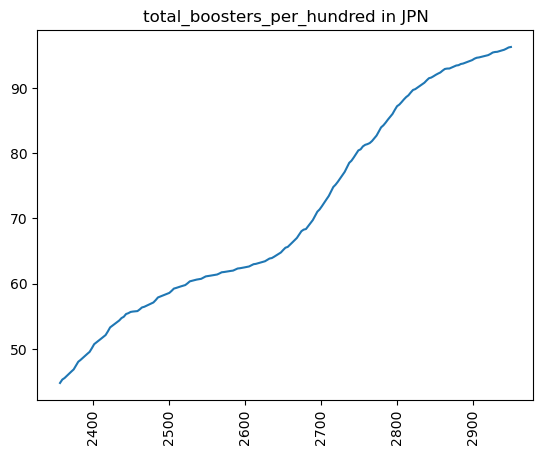

new_vaccinations_smoothed_per_million


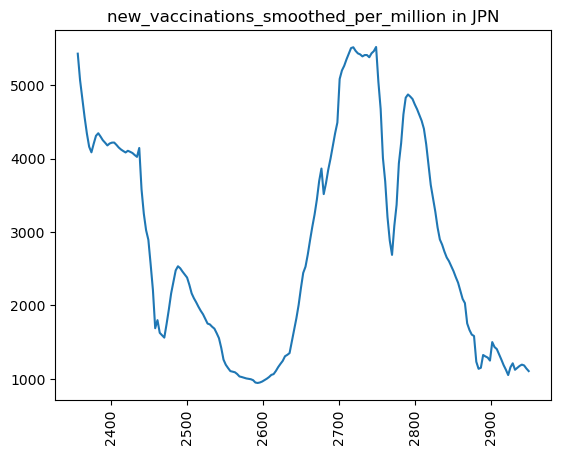

In [20]:
lastN = 200
simplePlot(db_conn,'NLD','vaccinations',lastN)
simplePlot(db_conn,'ITA','vaccinations',lastN)
simplePlot(db_conn,'JPN','vaccinations',lastN)